In [1]:
import os
import sys
sys.path.append('../../')

import pandas as pd
import xgboost as xgb
import numpy as np
import swifter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from datetime import datetime, timedelta
from tqdm import tqdm, tqdm_notebook
from category_encoders import TargetEncoder
import core.config as conf

In [2]:
tqdm_notebook().pandas()

/home/nyongja/anaconda3/envs/nh2021/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


0it [00:00, ?it/s]

## 01. Train Data Load

In [3]:
## load preprocessing data (past_d)
train_df = pd.read_csv('./result/train_past_d.csv')
test_df = pd.read_csv('./result/test_past_d.csv')

In [4]:
path = conf.data_path

In [15]:
train_df = pd.read_csv(f'{path}'+'stk_hld_train.csv')

In [6]:
train_df.head()

,act_id,iem_cd,byn_dt,hold_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A006360,20180726,11
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005930,20180131,80
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005070,20180517,5
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A003520,20201112,22
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A002310,20180905,324


In [7]:
cus_df = pd.read_csv(f'{path}'+'cus_info.csv')

In [8]:
cus_df.head()

,act_id,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd
0,64aae8dd71e5c0761000db9f9a6779e504e7a4aa9dc097...,1,4,99,1,2,3,3,6,16
1,5f7c3a8f37d9c268d06130ff0be5d32a1b9ef68c13049f...,1,6,4,4,2,5,2,6,1
2,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,2,7,4,3,2,5,5,6,9
3,6d497facfa1ea5901b827335553331f8555fec02a8184f...,2,6,4,4,8,5,3,6,16
4,b727c78d2cfc246c97b677f29a034399a0c7e7873fff44...,1,5,2,2,2,5,5,5,16


In [9]:
iem_df = pd.read_csv(f'{path}'+'iem_info_20210902.csv')

In [10]:
iem_df.head()

,iem_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd
0,A000020,동화약품,8,2,99
1,A000080,하이트진로,14,2,1
2,A000180,성창기업지주,5,3,99
3,A000227,유유제약2우B,8,99,99
4,A000325,노루홀딩스우,2,99,99


In [11]:
L_encoder = LabelEncoder()
L_encoder.fit(iem_df["iem_krl_nm"])

LabelEncoder()

In [12]:
iem_df['iem_krl_nm'] = L_encoder.transform(iem_df["iem_krl_nm"])

In [13]:
train_df = pd.merge(left = train_df, right = cus_df, how='left', on='act_id')

In [14]:
train_df = pd.merge(train_df, iem_df, how='left', on='iem_cd')

## 02. Test Data Load

In [15]:
test_df = pd.read_csv(f'{path}'+'stk_hld_test.csv')

In [16]:
test_df = pd.merge(left = test_df, right = cus_df, how='left', on='act_id')

In [17]:
test_df = pd.merge(test_df, iem_df, how='left', on='iem_cd')

In [18]:
test_df.head()

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A032640,20200522,153,IDX00001,0,1,9,3,2,2,9,5,5,8,418,4,1,1
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A160600,20190823,335,IDX00002,0,1,9,3,2,2,9,5,5,8,2230,10,3,99
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A234340,20200611,139,IDX00003,0,1,9,3,2,2,9,5,5,8,1515,13,2,99
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A131760,20200120,236,IDX00004,0,1,9,3,2,2,9,5,5,8,2681,13,3,99
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A293490,20201217,9,IDX00005,0,1,9,3,2,2,9,5,5,8,2450,13,1,2


## 03. Stock Hist

In [6]:
stk_df = pd.read_csv(f'{path}'+'stk_bnc_hist.csv')

In [6]:
stk_df.head()

,act_id,bse_dt,iem_cd,bnc_qty,tot_aet_amt,stk_par_pr
0,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200820,A008770,40.0,2828000.0,5000.0
1,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200623,A008770,20.0,1390000.0,5000.0
2,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20160104,A005940,311.0,2982490.0,5000.0
3,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200814,A005930,40.0,2320000.0,100.0
4,1119c23c3a504ca7b75060277410c0f6fb9018ec7638c2...,20200623,A005930,20.0,1028000.0,100.0


In [11]:
# past_d

In [7]:
def working_day(s_dt, e_dt) : # 공휴일 제외
    s_dt = str(s_dt).split('.')[0]
    e_dt = str(e_dt).split('.')[0]
    s_dt = s_dt[:4] + '-' + s_dt[4:6] + '-' + s_dt[6:]
    e_dt = e_dt[:4] + '-' + e_dt[4:6] + '-' + e_dt[6:]
    return np.busday_count(s_dt, e_dt, weekmask='1111100')

In [8]:
def stk_hist(act_id, iem_cd) :
    diff_date = []
    s_dt = 0
    tmp_df = stk_df[stk_df['act_id']==act_id][stk_df['iem_cd']==iem_cd][['bse_dt', 'bnc_qty']]
    if len(tmp_df) == 0 : return None

    sell = tmp_df[tmp_df['bnc_qty']==0.0]#매도
    trade = tmp_df[tmp_df['bnc_qty']!=0.0]#매매
    
    if len(sell) == 0 : # 판 기록이 없을 때
        t_dt = trade['bse_dt'].values[0]
        diff_date.append(working_day(t_dt, 20201231))
    elif len(trade) == 0 : # 산 기록이 없을 때
        s_dt = sell['bse_dt'].values[0]
        diff_date.append(working_day(20160101, s_dt))
    else : 
        for _, row in sell.iterrows() :
            s_dt = row['bse_dt']
            t_dt = trade[trade['bse_dt'] <= s_dt]['bse_dt'].values[0]
            trade = trade[trade['bse_dt'] > t_dt]
            diff_date.append(working_day(t_dt, s_dt))
        trade = trade[trade['bse_dt']>s_dt]
        if len(trade) != 0 :
            t_dt = trade['bse_dt'].values[0]
            diff_date.append(working_day(t_dt, 20201231))    
    return np.mean(diff_date)

In [10]:
stk_df[stk_df['act_id']=='feaf418a74ee66caa6b550ea26e1eb12d231a3ceb69d4b77954945ff183255c9'][stk_df['iem_cd']=='A066130']

/home/nyongja/anaconda3/envs/nh2021/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,act_id,bse_dt,iem_cd,bnc_qty,tot_aet_amt,stk_par_pr
2321872,feaf418a74ee66caa6b550ea26e1eb12d231a3ceb69d4b...,20190401,A066130,96.0,1022400.0,500.0
2321873,feaf418a74ee66caa6b550ea26e1eb12d231a3ceb69d4b...,20190403,A066130,0.0,0.0,500.0
2321874,feaf418a74ee66caa6b550ea26e1eb12d231a3ceb69d4b...,20191105,A066130,1863.0,13320450.0,500.0
2321875,feaf418a74ee66caa6b550ea26e1eb12d231a3ceb69d4b...,20191106,A066130,1958.0,14234660.0,500.0
2321876,feaf418a74ee66caa6b550ea26e1eb12d231a3ceb69d4b...,20191107,A066130,2107.0,14938630.0,500.0
2321877,feaf418a74ee66caa6b550ea26e1eb12d231a3ceb69d4b...,20191122,A066130,1863.0,12537990.0,500.0
2321878,feaf418a74ee66caa6b550ea26e1eb12d231a3ceb69d4b...,20200103,A066130,2142.0,16257780.0,500.0
2321879,feaf418a74ee66caa6b550ea26e1eb12d231a3ceb69d4b...,20200226,A066130,1142.0,8382280.0,500.0
2321880,feaf418a74ee66caa6b550ea26e1eb12d231a3ceb69d4b...,20200228,A066130,600.0,3870000.0,500.0
2321881,feaf418a74ee66caa6b550ea26e1eb12d231a3ceb69d4b...,20200302,A066130,0.0,0.0,500.0


In [24]:
diff_date = stk_hist('feaf418a74ee66caa6b550ea26e1eb12d231a3ceb69d4b77954945ff183255c9', 'A066130')

/home/nyongja/anaconda3/envs/nh2021/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [25]:
diff_date

43.0

## Data Preprocessing

#### Past_d

In [26]:
stk_df = stk_df.sort_values(by=['bse_dt'])

In [31]:
train_df['past_d'] = train_df.swifter.progress_bar().apply(lambda x : stk_hist(x['act_id'], x['iem_cd']), axis = 1)

/home/nyongja/anaconda3/envs/nh2021/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/home/nyongja/anaconda3/envs/nh2021/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/home/nyongja/anaconda3/envs/nh2021/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/home/nyongja/anaconda3/envs/nh2021/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/home/nyongja/anaconda3/envs/nh2021/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removin

Dask Apply:   0%|          | 0/40 [00:00<?, ?it/s]

/home/nyongja/anaconda3/envs/nh2021/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/home/nyongja/anaconda3/envs/nh2021/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/home/nyongja/anaconda3/envs/nh2021/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/home/nyongja/anaconda3/envs/nh2021/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/home/nyongja/anaconda3/envs/nh2021/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removin

In [40]:
test_df['past_d'] = test_df.apply(lambda x : stk_hist(x['act_id'], x['iem_cd']), axis = 1)

/home/nyongja/anaconda3/envs/nh2021/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


#### user avg past_d : 사용자 별 past_d
#### iem avg past_d : 종목 별 평균 past_d
#### ivs  icn avg past_d : 투자성향 별 평균 past_d
#### mkt_pr_tal_scl_tp_cd : 시가총액 규모 별 평균 past_d
-> 제대로 하려면 stk_hist 파일 돌려서 다시 구해야 함

In [7]:
user_avg_pastd = train_df['past_d'].groupby(train_df['act_id']).mean()

In [8]:
iem_avg_pastd = train_df['past_d'].groupby(train_df['iem_cd']).mean()

In [9]:
ivs_icn_avg_pastd = train_df['past_d'].groupby(train_df['ivs_icn_cd']).mean()

In [10]:
user_avg_pastd_test = test_df['past_d'].groupby(test_df['act_id']).mean()

In [11]:
iem_avg_pastd_test = test_df['past_d'].groupby(test_df['iem_cd']).mean()

In [12]:
mkt_pr_avg_pastd = train_df['past_d'].groupby(train_df['mkt_pr_tal_scl_tp_cd']).mean()

In [13]:
train_df['user_avg_past_d'] = train_df.apply(lambda x : user_avg_pastd[x['act_id']], axis = 1)

In [14]:
train_df['iem_avg_past_d'] = train_df.apply(lambda x : iem_avg_pastd[x['iem_cd']], axis = 1)

In [15]:
train_df['ivs_icn_past_d'] = train_df.apply(lambda x : ivs_icn_avg_pastd[x['ivs_icn_cd']], axis = 1)

In [16]:
train_df['mkt_pr_past_d'] = train_df.apply(lambda x : mkt_pr_avg_pastd[x['mkt_pr_tal_scl_tp_cd']], axis = 1)

In [17]:
test_df['user_avg_past_d'] = test_df.apply(lambda x : user_avg_pastd[x['act_id']] if x['act_id'] in user_avg_pastd else user_avg_pastd_test[x['act_id']], axis = 1)

In [18]:
test_df['iem_avg_past_d'] = test_df.apply(lambda x : iem_avg_pastd[x['iem_cd']] if x['iem_cd'] in iem_avg_pastd else iem_avg_pastd_test[x['iem_cd']], axis = 1)

In [19]:
test_df['ivs_icn_past_d'] = test_df.apply(lambda x : ivs_icn_avg_pastd[x['ivs_icn_cd']], axis = 1)

In [20]:
test_df['mkt_pr_past_d'] = test_df.apply(lambda x : mkt_pr_avg_pastd[x['mkt_pr_tal_scl_tp_cd']], axis = 1)

In [21]:
train_df.head()

,act_id,iem_cd,byn_dt,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,...,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,past_d,hist_d,user_avg_past_d,iem_avg_past_d,ivs_icn_past_d,mkt_pr_past_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A006360,20180726,11,1,9,3,2,2,9,...,101,1,1,1,195.0,6.6,41.074468,66.392544,39.918768,58.505146
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005930,20180131,80,1,9,3,2,2,9,...,1361,9,1,1,86.0,48.0,41.074468,101.057144,39.918768,58.505146
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005070,20180517,5,1,9,3,2,2,9,...,2530,12,2,99,6.0,3.0,41.074468,44.857150,39.918768,40.248910
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A003520,20201112,22,1,9,3,2,2,9,...,1969,8,2,1,22.0,13.2,41.074468,44.580025,39.918768,40.248910
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A002310,20180905,324,1,9,3,2,2,9,...,1696,10,3,99,347.0,194.4,41.074468,81.323587,39.918768,36.059944


In [22]:
test_df.head()

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,...,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,past_d,user_avg_past_d,iem_avg_past_d,ivs_icn_past_d,mkt_pr_past_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A032640,20200522,153,IDX00001,0,1,9,3,2,...,8,418,4,1,1,159.0,41.074468,87.701799,39.918768,58.505146
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A160600,20190823,335,IDX00002,0,1,9,3,2,...,8,2230,10,3,99,354.0,41.074468,33.203922,39.918768,36.059944
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A234340,20200611,139,IDX00003,0,1,9,3,2,...,8,1515,13,2,99,145.0,41.074468,31.919831,39.918768,40.248910
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A131760,20200120,236,IDX00004,0,1,9,3,2,...,8,2681,13,3,99,248.0,41.074468,37.868490,39.918768,36.059944
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A293490,20201217,9,IDX00005,0,1,9,3,2,...,8,2450,13,1,2,10.0,41.074468,15.034166,39.918768,58.505146


#### hist d : 

In [5]:
train_df["hist_d"] = train_df["hold_d"]*0.6

In [6]:
train_df.head()

,act_id,iem_cd,byn_dt,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,past_d,hist_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A006360,20180726,11,1,9,3,2,2,9,5,5,8,101,1,1,1,195.0,6.6
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005930,20180131,80,1,9,3,2,2,9,5,5,8,1361,9,1,1,86.0,48.0
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A005070,20180517,5,1,9,3,2,2,9,5,5,8,2530,12,2,99,6.0,3.0
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A003520,20201112,22,1,9,3,2,2,9,5,5,8,1969,8,2,1,22.0,13.2
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A002310,20180905,324,1,9,3,2,2,9,5,5,8,1696,10,3,99,347.0,194.4


In [7]:
test_df.head()

,act_id,iem_cd,byn_dt,hist_d,submit_id,hold_d,sex_dit_cd,cus_age_stn_cd,ivs_icn_cd,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,tco_cus_grd_cd,tot_ivs_te_sgm_cd,mrz_btp_dit_cd,iem_krl_nm,btp_cfc_cd,mkt_pr_tal_scl_tp_cd,stk_dit_cd,past_d
0,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A032640,20200522,153,IDX00001,0,1,9,3,2,2,9,5,5,8,418,4,1,1,159.0
1,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A160600,20190823,335,IDX00002,0,1,9,3,2,2,9,5,5,8,2230,10,3,99,354.0
2,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A234340,20200611,139,IDX00003,0,1,9,3,2,2,9,5,5,8,1515,13,2,99,145.0
3,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A131760,20200120,236,IDX00004,0,1,9,3,2,2,9,5,5,8,2681,13,3,99,248.0
4,0ad104dbed99be0cd858aa772765ddedade554601a981b...,A293490,20201217,9,IDX00005,0,1,9,3,2,2,9,5,5,8,2450,13,1,2,10.0


## External Data Featuring

In [5]:
external_path = conf.external_path

In [6]:
stk_mean_df = pd.read_csv(external_path+'mean_stockdata.csv')

In [7]:
stk_mean_df['code'] = stk_mean_df.apply(lambda x : 'A' + x['code'], axis = 1)

In [8]:
stk_mean_df

,code,oepn,high,low,close,volume,chage
0,A000020,10628.321108,10875.158924,10395.338223,10611.340668,4.514417e+05,0.001178
1,A000080,13718.842105,13873.710526,13566.907895,14156.565789,1.592198e+06,0.000800
2,A000180,3205.013040,3268.528117,3137.779136,3229.211084,1.243295e+06,-0.000945
3,A000227,13186.233089,13408.596577,12970.257539,13402.982885,3.864996e+04,-0.000098
4,A000325,18285.819071,18510.423798,18045.867971,18283.928280,1.757751e+05,0.000082
...,...,...,...,...,...,...,...
2807,A156080,10585.937500,10747.812500,10474.375000,10595.937500,2.414732e+05,0.007861
2808,A160980,10113.500000,10179.500000,9927.500000,10037.000000,1.963900e+04,0.000063
2809,A161580,10127.000000,10232.000000,9951.000000,10080.000000,8.949426e+05,0.001339
2810,A163730,10156.500000,10307.250000,10123.000000,10264.500000,9.705650e+04,0.016875


In [9]:
train_df = pd.merge(left = train_df, right = stk_mean_df[['code', 'volume']], how='left', left_on='iem_cd', right_on = 'code')

In [10]:
test_df = pd.merge(left = test_df, right = stk_mean_df[['code', 'volume']], how='left', left_on='iem_cd', right_on = 'code')

## Target Encoding

In [11]:
target_encoder = TargetEncoder()

In [12]:
target_encoder.fit(train_df['iem_cd'], train_df['hold_d'])

TargetEncoder(cols=['iem_cd'])

In [13]:
train_df['iem_cd_te'] = target_encoder.transform(train_df['iem_cd'], train_df['hold_d'])

In [14]:
test_df['iem_cd_te'] = target_encoder.transform(test_df['iem_cd'], test_df['hold_d'])

In [15]:
test_df = test_df.fillna(0)

In [16]:
train_df = train_df.fillna(0)

In [24]:
#target_encoder.transform(train_df['ivs_icn_cd'], train_df['hold_d'])

,ivs_icn_cd
0,3
1,3
2,3
3,3
4,3
...,...
681467,4
681468,4
681469,4
681470,4


## Drop Features

In [17]:
train_df = train_df.drop(['act_id', 'iem_cd', 'code', 'byn_dt'], axis = 1)

In [18]:
used_features = train_df.columns.drop('hold_d')

In [19]:
test_df = test_df[used_features]

In [20]:
train_df.columns

Index(['hold_d', 'sex_dit_cd', 'cus_age_stn_cd', 'ivs_icn_cd',
       'cus_aet_stn_cd', 'mrz_pdt_tp_sgm_cd', 'lsg_sgm_cd', 'tco_cus_grd_cd',
       'tot_ivs_te_sgm_cd', 'mrz_btp_dit_cd', 'iem_krl_nm', 'btp_cfc_cd',
       'mkt_pr_tal_scl_tp_cd', 'stk_dit_cd', 'past_d', 'hist_d', 'volume',
       'iem_cd_te'],
      dtype='object')

In [21]:
test_df.columns

Index(['sex_dit_cd', 'cus_age_stn_cd', 'ivs_icn_cd', 'cus_aet_stn_cd',
       'mrz_pdt_tp_sgm_cd', 'lsg_sgm_cd', 'tco_cus_grd_cd',
       'tot_ivs_te_sgm_cd', 'mrz_btp_dit_cd', 'iem_krl_nm', 'btp_cfc_cd',
       'mkt_pr_tal_scl_tp_cd', 'stk_dit_cd', 'past_d', 'hist_d', 'volume',
       'iem_cd_te'],
      dtype='object')

## 03. XGBoost

In [22]:
col = train_df.columns

In [23]:
col = col.drop('hold_d')

In [24]:
TARGET = 'hold_d'

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df[col], train_df[TARGET], test_size = 0.2)

In [26]:
model = xgb.XGBRegressor(n_estimators=1000, max_depth=8, min_child_weighteta=0.1, subsample=0.7, colsample_bytree=0.8)

#### GridSearch

In [48]:
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'eta' :[0.05, 0.1],
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7, 8],
              'min_child_weight': [1, 2, 4, 6],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500, 1000]}

xgb_grid = GridSearchCV(model,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

In [27]:
model.fit(X_train, y_train, verbose=False)

[20:07:04] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=1, min_child_weighteta=0.1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=20,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.7, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [50]:
xgb_grid.fit(X_train, y_train, verbose=False)

Fitting 2 folds for each of 192 candidates, totalling 384 fits
[20:21:21] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:21:21] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:21:53] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:21:53] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.

/home/nyongja/anaconda3/envs/nh2021/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[20:21:21] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:21:21] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:21:52] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:21:52] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:22:57] WARNING: ../src/objective/regression_obj.cu:171: 

[20:21:20] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:21:20] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:22:23] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:22:23] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:22:55] WARNING: ../src/objective/regression_obj.cu:171: 

[20:21:21] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:21:21] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:22:25] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:22:25] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:23:25] WARNING: ../src/objective/regression_obj.cu:171: 


[20:37:52] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:37:52] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:39:10] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:39:10] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:39:47] WARNING: ../src/objective/regression_obj.cu:171:

[20:35:35] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:35:35] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:36:07] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:36:07] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:37:12] WARNING: ../src/objective/regression_obj.cu:171: 

[20:45:52] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:45:52] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:46:45] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:46:45] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:47:38] WARNING: ../src/objective/regression_obj.cu:171: 

[20:46:08] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:46:08] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:47:49] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:47:49] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:48:22] WARNING: ../src/objective/regression_obj.cu:171: 

[20:47:11] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:47:11] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:48:51] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:48:51] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:49:23] WARNING: ../src/objective/regression_obj.cu:171: 

[20:46:32] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:46:33] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:47:25] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:47:25] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:49:07] WARNING: ../src/objective/regression_obj.cu:171: 


[20:52:45] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:52:45] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:53:25] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[20:53:25] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:54:40] WARNING: ../src/objective/regression_obj.cu:171:


[21:05:26] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[21:05:26] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:06:05] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[21:06:05] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:07:28] WARNING: ../src/objective/regression_obj.cu:171:


[21:03:17] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[21:03:17] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:03:49] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[21:03:49] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:04:52] WARNING: ../src/objective/regression_obj.cu:171:


[21:04:45] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[21:04:45] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:05:26] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[21:05:26] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:06:48] WARNING: ../src/objective/regression_obj.cu:171:


[21:06:12] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[21:06:12] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:06:55] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[21:06:55] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:07:41] WARNING: ../src/objective/regression_obj.cu:171:


[21:11:10] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[21:11:10] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:12:57] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[21:12:57] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:13:51] WARNING: ../src/objective/regression_obj.cu:171:


[21:23:11] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[21:23:11] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:23:56] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[21:23:56] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:24:49] WARNING: ../src/objective/regression_obj.cu:171:

[21:42:33] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[21:42:33] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=8, min_child_weight=1,
                                    min_child_weighteta=0.1, missing=nan,
                                    monotone_constraints='()',
                                    n_estimators=...
                                    scale_pos_weight=1, subsample=0.7,
                                    tree_method='exact', validate_parameters=1,
                                    verbosity=None),
             n_jobs=5,
             param_grid={'colsample_bytree': [0.7], 'eta': [0.05,

In [51]:
import joblib

In [52]:
joblib.dump(xgb_grid, 'xgb_gridcv.pkl')

['xgb_gridcv.pkl']


[21:23:02] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[21:23:02] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:24:32] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[21:24:32] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:26:19] WARNING: ../src/objective/regression_obj.cu:171:


[21:26:01] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[21:26:01] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:27:47] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[21:27:47] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:29:31] WARNING: ../src/objective/regression_obj.cu:171:


[21:41:24] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[21:41:24] WARNING: ../src/learner.cc:573: 
Parameters: { "min_child_weighteta", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

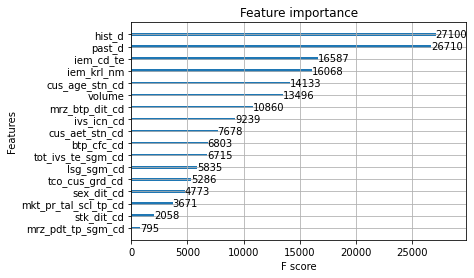

In [53]:
xgb.plot_importance(model)

In [54]:
xgb_grid.score(X_train, y_train)   

0.9997696402308622

In [31]:
model.score(X_train, y_train)

0.9999867422859888

## Predict Score

In [55]:
pred = model.predict(X_valid)

In [56]:
pred = xgb_grid.predict(X_valid)

In [57]:
y_valid.values

array([219,  35,   3, ...,  25,  12,   1])

In [58]:
np.round(pred)

array([217.,  35.,   3., ...,  25.,  12.,   1.], dtype=float32)

In [59]:
np.sqrt(mean_squared_error(y_valid.values, np.round(pred)))

1.0913854489469248

## 04. Submission

In [60]:
submission = pd.read_csv(f"{path}"+"sample_submission.csv")

In [61]:
y_pred = xgb_grid.predict(test_df) 

In [40]:
y_pred = model.predict(test_df)

In [62]:
y_pred

array([262.17017 , 538.69806 , 236.65643 , ..., 837.1912  ,  17.529884,
         7.297654], dtype=float32)

In [63]:
result = []
for i in y_pred:
    result.append(i)

In [64]:
result

[262.17017,
 538.69806,
 236.65643,
 407.41925,
 15.097428,
 154.07393,
 166.79492,
 895.4324,
 134.69582,
 846.0429,
 190.73862,
 1073.7126,
 777.76355,
 10.086613,
 17.515676,
 5.060085,
 186.04292,
 117.912766,
 472.7876,
 13.158538,
 9.716627,
 1079.3829,
 693.692,
 27.17785,
 3.0319393,
 113.86669,
 113.71391,
 411.71497,
 776.4708,
 475.455,
 115.30905,
 115.57781,
 876.56067,
 221.32433,
 20.222324,
 129.85284,
 221.36923,
 1137.811,
 220.93466,
 1114.1104,
 1134.4373,
 714.29065,
 1110.9607,
 1142.1221,
 1101.578,
 906.4524,
 1097.6914,
 1125.648,
 1130.0623,
 1116.7528,
 1129.7283,
 1107.7225,
 236.54611,
 859.3699,
 875.2191,
 238.63557,
 207.14493,
 857.93146,
 845.88226,
 900.32404,
 124.24073,
 874.3485,
 874.1496,
 860.4746,
 848.3393,
 882.93024,
 891.9329,
 131.67165,
 203.1191,
 862.7562,
 884.49756,
 868.3136,
 877.0249,
 1103.4868,
 19.813887,
 249.67053,
 42.923107,
 39.760513,
 245.9116,
 17.59465,
 1.9488803,
 1044.7599,
 1163.369,
 987.6103,
 12.07229,
 298.59772

In [65]:
submission["hold_d"] = np.round(result)

In [66]:
submission

,submit_id,hold_d
0,IDX00001,262.0
1,IDX00002,539.0
2,IDX00003,237.0
3,IDX00004,407.0
4,IDX00005,15.0
...,...,...
70591,IDX70592,37.0
70592,IDX70593,169.0
70593,IDX70594,837.0
70594,IDX70595,18.0


In [68]:
submission.to_csv("./result/gridcv_xgboost(iem_cd_target_encoding lib with hist_d volume).csv", index = False)